In [3]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint


## Obtain data from  CoinGecko API

In [4]:
response = requests.get("https://min-api.cryptocompare.com/data/all/coinlist")
coinlist = response.json()['Data']
print(f"Total coins: {len(coinlist)}")

Total coins: 18556


In [5]:
coinlist_ids = list(coinlist.keys())

In [6]:
import time
import pandas as pd
import requests

def get_hist_all(symbol, currency='USD', limit=1500, start_date=None, sleep=0.25):
    """
    Fetch daily history for `symbol` going back until `start_date` (inclusive).
    Uses paging (toTs) and finally slices to start_date to avoid overshooting.
    """
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    frames = []
    end_ts = None

    start_ts = None
    if start_date is not None:
        start_ts = int(pd.to_datetime(start_date).timestamp())

    while True:
        params = {'fsym': symbol, 'tsym': currency, 'limit': limit}
        if end_ts is not None:
            params['toTs'] = end_ts

        r = requests.get(url, params=params).json()
        if r.get('Response') != 'Success':
            print("API error:", r.get('Message'))
            break

        data = r['Data']['Data']
        if not data:
            break

        df = pd.DataFrame(data)
        frames.append(df)

        earliest = int(df['time'].min())

        # stop if we've reached or passed requested start_date (give one-day tolerance)
        if start_ts is not None and earliest <= start_ts + 86400:
            break

        # if API returned fewer than limit points, no more older data available
        if len(df) < limit:
            break

        # set next toTs to one day before earliest to avoid overlap
        end_ts = earliest - 86400
        time.sleep(sleep)

    if not frames:
        return None

    full = pd.concat(frames, ignore_index=True).drop_duplicates(subset='time').sort_values('time')
    full['time'] = pd.to_datetime(full['time'], unit='s')
    full = full.set_index('time')

    # enforce start_date slice to avoid extra history
    if start_date is not None:
        full = full[full.index >= pd.to_datetime(start_date)]

    # keep only close column renamed to symbol
    full = full[['close']].rename(columns={'close': symbol})
    return full

In [7]:
price_dfs = []
# Example: get top 10 coins
symbols = [
    "BTC", "ETH", "BNB", "XRP", "SOL", "DOGE", "TRX", "ADA",
    "AVAX", "DOT", "MATIC", "LTC", "SHIB", "LINK", "BCH", "ALGO", "NEAR", "XLM",
    "ATOM", "VET", "EOS", "FIL", "APE", "ICP", "SUI", "FTM", "AAVE", "GRT",
    "HBAR", "XMR", "THETA", "MANA", "ZEC", "NEKO", "MKR", "LDO", "SNX", "CRO"
]
for sym in symbols:
    print(f"Fetching data for {sym}...")
    df = get_hist_all(sym, start_date='2020-01-01')
    if df is not None:
        price_dfs.append(df)
    time.sleep(0.1)  # Respect rate limit

df_all = pd.concat(price_dfs, axis=1)
df_all = df_all.reset_index()

Fetching data for BTC...
Fetching data for ETH...
Fetching data for BNB...
Fetching data for XRP...
Fetching data for SOL...
Fetching data for DOGE...
Fetching data for TRX...
Fetching data for ADA...
Fetching data for AVAX...
Fetching data for DOT...
Fetching data for MATIC...
Fetching data for LTC...
Fetching data for SHIB...
Fetching data for LINK...
Fetching data for BCH...
Fetching data for ALGO...
Fetching data for NEAR...
Fetching data for XLM...
Fetching data for ATOM...
Fetching data for VET...
Fetching data for EOS...
Fetching data for FIL...
Fetching data for APE...
Fetching data for ICP...
Fetching data for SUI...
Fetching data for FTM...
Fetching data for AAVE...
Fetching data for GRT...
Fetching data for HBAR...
Fetching data for XMR...
Fetching data for THETA...
Fetching data for MANA...
Fetching data for ZEC...
Fetching data for NEKO...
Fetching data for MKR...
Fetching data for LDO...
Fetching data for SNX...
Fetching data for CRO...


In [8]:
df_all

,time,BTC,ETH,BNB,XRP,SOL,DOGE,TRX,ADA,AVAX,...,HBAR,XMR,THETA,MANA,ZEC,NEKO,MKR,LDO,SNX,CRO
0,2020-01-01,7189.94,130.57,13.68,0.1931,0.00,0.002124,0.01376,0.03381,0.00,...,0.01024,45.78,0.08647,0.03136,27.95,0.000000,437.80,0.0000,1.2320,0.03372
1,2020-01-02,6965.72,127.05,13.00,0.1874,0.00,0.002089,0.01303,0.03437,0.00,...,0.01009,45.51,0.08443,0.03210,27.28,0.000000,422.61,0.0000,1.1190,0.03260
2,2020-01-03,7339.70,134.24,13.65,0.1933,0.00,0.002109,0.01377,0.03461,0.00,...,0.01038,50.97,0.08767,0.03280,28.34,0.000000,434.30,0.0000,1.1570,0.03442
3,2020-01-04,7357.50,134.20,13.80,0.1930,0.00,0.002108,0.01384,0.03493,0.00,...,0.01111,50.37,0.09390,0.03412,30.01,0.000000,436.98,0.0000,1.1530,0.03436
4,2020-01-05,7359.96,135.50,14.04,0.1947,0.00,0.002126,0.01388,0.03465,0.00,...,0.01158,53.70,0.09454,0.03622,30.69,0.000000,438.14,0.0000,1.1170,0.03407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,2025-11-05,103893.50,3424.12,960.08,2.3430,162.38,0.167200,0.28890,0.54520,16.62,...,0.17520,342.28,0.42910,0.21210,479.11,0.000035,1225.88,0.7683,0.8507,0.12460
2136,2025-11-06,101302.75,3313.99,950.12,2.2120,155.22,0.161600,0.28370,0.53150,16.12,...,0.16310,361.12,0.41790,0.21180,535.90,0.000029,1189.06,0.7366,0.8090,0.12260
2137,2025-11-07,103301.61,3434.31,990.77,2.3140,161.72,0.178700,0.29210,0.57610,17.73,...,0.17700,367.03,0.51770,0.23700,644.07,0.000028,1306.21,0.8340,0.8839,0.13000
2138,2025-11-08,102304.79,3400.93,990.51,2.2860,157.98,0.176000,0.29150,0.56870,17.50,...,0.17560,365.67,0.50380,0.23570,602.11,0.000029,1223.30,0.8085,0.8351,0.12520


<Axes: title={'center': 'Some Crypto Prices'}>

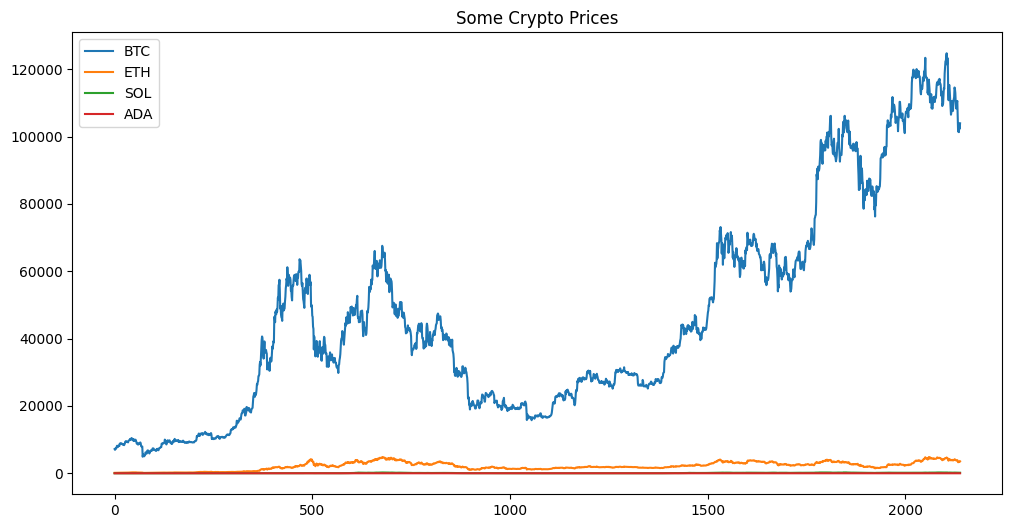

In [9]:
selected_cols = ["BTC", "ETH", "SOL", "ADA"]  # Replace with your actual column names
df_all[selected_cols].plot(figsize=(12, 6), title="Some Crypto Prices")

In [10]:
# --- Load and clean ---
df = df_all.copy()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

<Axes: title={'center': 'Percentage of Zero Values per Crypto'}>

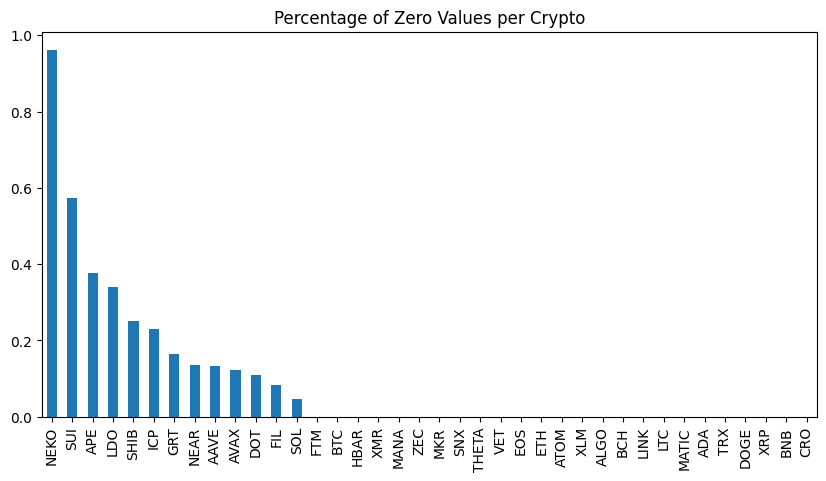

In [11]:
# check percentage of 0 values per column and plot
zero_pct = (df == 0).mean()
zero_pct.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Percentage of Zero Values per Crypto")

In [12]:
df = df.replace(0, np.nan) # remove the impact of 0 values

# --- Fill small gaps ---
df = df.fillna(method='ffill')

# # --- Compute log returns ---
returns = np.log(df / df.shift(1))
returns = returns.dropna(axis=0, how='all')  # Drop rows where all values are NaN

/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/1874849299.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [13]:
returns

,BTC,ETH,BNB,XRP,SOL,DOGE,TRX,ADA,AVAX,DOT,...,HBAR,XMR,THETA,MANA,ZEC,NEKO,MKR,LDO,SNX,CRO
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.031682,-0.027329,-0.050986,-0.029963,NaN,-0.016616,-0.054511,0.016427,NaN,NaN,...,-0.014757,-0.005915,-0.023875,0.023323,-0.024263,NaN,-0.035312,NaN,-0.096203,-0.033779
2020-01-03,0.052297,0.055049,0.048790,0.030998,NaN,0.009528,0.055238,0.006959,NaN,NaN,...,0.028336,0.113305,0.037657,0.021572,0.038120,NaN,0.027286,NaN,0.033395,0.054326
2020-01-04,0.002422,-0.000298,0.010929,-0.001553,NaN,-0.000474,0.005071,0.009203,NaN,NaN,...,0.067965,-0.011841,0.068651,0.039455,0.057256,NaN,0.006152,NaN,-0.003463,-0.001745
2020-01-05,0.000334,0.009640,0.017242,0.008770,NaN,0.008503,0.002886,-0.008048,NaN,NaN,...,0.041434,0.064017,0.006793,0.059728,0.022406,NaN,0.002651,NaN,-0.031721,-0.008476
2020-01-06,0.053274,0.061883,0.063470,0.137504,NaN,0.030116,0.056037,0.075571,NaN,NaN,...,-0.039635,0.093277,0.058145,-0.026579,0.062214,NaN,0.056117,NaN,-0.186880,0.051484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,0.023374,0.040903,0.024525,0.060705,0.046321,0.030361,0.012189,0.045979,0.038643,0.062593,...,0.038399,0.012731,0.041881,0.054748,0.082001,0.215937,-0.022679,0.056768,0.004359,0.026018
2025-11-06,-0.025253,-0.032692,-0.010428,-0.057535,-0.045096,-0.034067,-0.018163,-0.025450,-0.030546,-0.001124,...,-0.071565,0.053581,-0.026448,-0.001415,0.112017,-0.189624,-0.030496,-0.042135,-0.050261,-0.016182
2025-11-07,0.019539,0.035663,0.041894,0.045081,0.041023,0.100584,0.029179,0.080578,0.095197,0.198623,...,0.081786,0.016233,0.214154,0.112418,0.183860,-0.026668,0.093967,0.124188,0.088545,0.058607


In [16]:
def QP(y, sigma ):
    
    v = 0.5 * y.T @ sigma @ y 
    
    return v


def compute_erc_weights(cov, QP=QP):
    """
    Compute ERC portfolio weights.
    Drops all-NaN symbols but returns full-length weight vector (zero-filled for dropped).
    
    Parameters:
    - cov: pandas.DataFrame (n x n) covariance matrix
    - QP: ERC objective function (takes w, cov)

    Returns:
    - weights: pd.Series, index = all original columns, dropped symbols = 0
    """

    # Save original columns
    all_symbols = cov.columns.copy()

    # Identify and drop invalid assets
    dropped_cols = cov.columns[cov.isna().all()]
    print("Dropped symbols (all NaN):", dropped_cols.tolist())

    # Drop NaN rows and columns
    cov_clean = cov.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cov_clean = cov_clean.loc[cov_clean.columns, cov_clean.columns]  # ensure symmetry

    n = cov_clean.shape[0]
    x0 = np.ones(n) / n

    # Log constraint to keep positivity
    logy = lambda y: np.sum(np.log(y))

    constraints = [LinearConstraint(np.eye(x0.shape[0]), lb = 0, ub = 1), NonlinearConstraint(logy, lb = -n * np.log(n) - 2, ub=np.inf)]

    result = minimize(QP, x0, args=(cov_clean,), constraints=constraints)
    w_clean = result.x
    w_clean = w_clean / np.sum(w_clean)
    rc_df_clean = compute_rc(cov_clean.values, w_clean)

    # Fill into full-length vector
    weights_full = pd.Series(0.0, index=all_symbols)
    weights_full.loc[cov_clean.columns] = w_clean

    # Prepare empty full rc dataframe with same columns as rc_df_clean
    rc_df_full = pd.DataFrame(index=all_symbols, columns=rc_df_clean.columns)
    # Fill rows for assets with covariance
    rc_df_full.loc[cov_clean.columns] = rc_df_clean.values

    # For dropped symbols, set Weight = 0 and other numeric fields to 0 (or keep NaN if preferred)
    for col in rc_df_full.columns:
        if col == 'Weight':
            rc_df_full[col] = rc_df_full[col].fillna(0.0)
        else:
            # fill numeric fields with 0.0; if you prefer NaN for missing, remove this line
            rc_df_full[col] = rc_df_full[col].fillna(0.0)

    # Ensure proper dtypes
    rc_df_full = rc_df_full.astype(float)

    return weights_full, rc_df_full

def compute_rc(cov, weights):
    """
    Compute risk contributions given covariance matrix and weights.
    cov: numpy array (n,n) or pandas.DataFrame
    weights: numpy array (n,)
    returns: risk contributions (numpy array)
    """
    # Portfolio volatility
    port_std = np.sqrt(weights @ (cov @ weights))

    # Marginal contribution = Σw
    marginal_contrib = cov @ weights

    # Risk contribution (in % of total portfolio risk)
    rc = weights * marginal_contrib
    rc_pct = rc / port_std

    # Display
    rc_df = pd.DataFrame({
        'Weight': weights,
        'Marginal RC': marginal_contrib,
        'Risk Contribution': rc,
        'RC % of Total': rc_pct,
        'Portfolio volatility':port_std
    })
    return rc_df

In [14]:
rets = returns.copy()  # returns: daily log or arithmetic returns
years = sorted(rets.index.year.unique())

weights_by_year = {}
monthly_portfolio_returns = []
rc_dfs = []

for i in range(1, len(years)):

    print(f"Processing year: {years[i]} using historical year: {years[i - 1]}")
    hist_year = years[i - 1]
    apply_year = years[i]

    hist_data = rets[rets.index.year == hist_year]
    apply_data = rets[rets.index.year == apply_year]

    # Step 1: Estimate covariance
    cov = hist_data.cov()

    # Step 2: Compute ERC weights (now returns full-weight Series)
    w_series, rc_df = compute_erc_weights(cov, QP)
    rc_dfs.append(rc_df)

    # Save weights for inspection
    weights_by_year[apply_year] = w_series

    # Step 3: Apply weights to daily returns
    # Align weights with apply_data columns (fill missing symbols with 0)
    w_vec = w_series.reindex(apply_data.columns).fillna(0).values

    # Daily portfolio arithmetic returns
    apply_data = apply_data.fillna(0)  # Treat NaN returns as 0 for daily calculation
    daily_portfolio = apply_data.values @ w_vec
    daily_series = pd.Series(daily_portfolio, index=apply_data.index)

    # Step 4: Aggregate to monthly returns (compound daily returns)
    monthly_series = (1 + daily_series).resample('M').prod() - 1
    monthly_portfolio_returns.append(monthly_series)



Processing year: 2021 using historical year: 2020
Dropped symbols (all NaN): ['SHIB', 'APE', 'ICP', 'SUI', 'NEKO', 'LDO']
Processing year: 2022 using historical year: 2021
Dropped symbols (all NaN): ['APE', 'SUI', 'NEKO']
Processing year: 2023 using historical year: 2022
Dropped symbols (all NaN): ['SUI', 'NEKO']


/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/141933447.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/929443435.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = (1 + daily_s

Processing year: 2024 using historical year: 2023
Dropped symbols (all NaN): ['NEKO']
Processing year: 2025 using historical year: 2024
Dropped symbols (all NaN): ['NEKO']


/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/141933447.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_19551/929443435.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = (1 + daily_s

In [22]:
rets = returns.copy()  # returns: daily log or arithmetic returns
years = sorted(rets.index.year.unique())

weights_by_year = {}
daily_portfolio = []
rc_dfs = []

daily_portfolio_returns = []   # move outside the year loop!

for i in range(1, len(years)):

    print(f"Processing year: {years[i]} using historical year: {years[i - 1]}")
    hist_year = years[i - 1]
    apply_year = years[i]

    hist_data = rets[rets.index.year == hist_year]
    apply_data = rets[rets.index.year == apply_year].fillna(0)  # fill here

    # Step 1: Estimate covariance
    cov = hist_data.cov()

    # Step 2: Compute ERC weights
    w_series, rc_df = compute_erc_weights(cov, QP)
    rc_dfs.append(rc_df)
    weights_by_year[apply_year] = w_series

    # Align weights to apply_data columns
    current_weights = w_series.reindex(apply_data.columns).fillna(0).values

    # Step 3: Simulate portfolio performance (drifting weights, no rebalancing)
    year_returns = []
    for t in range(len(apply_data)):
        r_t = apply_data.iloc[t].values
        port_ret = np.dot(current_weights, r_t)
        year_returns.append(port_ret)

        # Update weights naturally
        growth = current_weights * (1 + r_t)
        total = growth.sum()
        if total == 0 or np.isnan(total):
            # skip or break if weights explode
            continue
        current_weights = growth / total

    # Save yearly daily returns
    daily_portfolio_returns.append(pd.Series(year_returns, index=apply_data.index))

# Combine all years
daily_portfolio = pd.concat(daily_portfolio_returns).sort_index()



Processing year: 2021 using historical year: 2020
Dropped symbols (all NaN): ['SHIB', 'APE', 'ICP', 'SUI', 'NEKO', 'LDO']
Processing year: 2022 using historical year: 2021
Dropped symbols (all NaN): ['APE', 'SUI', 'NEKO']
Processing year: 2023 using historical year: 2022
Dropped symbols (all NaN): ['SUI', 'NEKO']


/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call 

Processing year: 2024 using historical year: 2023
Dropped symbols (all NaN): ['NEKO']
Processing year: 2025 using historical year: 2024
Dropped symbols (all NaN): ['NEKO']


/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rc_df_full[col] = rc_df_full[col].fillna(0.0)
/var/folders/zp/y0mkwy7d4jz3mdv2npxr4v2c0000gn/T/ipykernel_20239/141933447.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call 

In [23]:
rc_dfs[2]

,Weight,Marginal RC,Risk Contribution,RC % of Total,Portfolio volatility
BTC,0.040593,0.001339,0.000054,0.001229,0.044212
ETH,0.029393,0.001848,0.000054,0.001229,0.044212
BNB,0.034573,0.001569,0.000054,0.001227,0.044212
XRP,0.031975,0.001698,0.000054,0.001228,0.044212
SOL,0.021660,0.002507,0.000054,0.001228,0.044212
DOGE,0.028924,0.001878,0.000054,0.001228,0.044212
TRX,0.057679,0.000941,0.000054,0.001228,0.044212
ADA,0.028319,0.001918,0.000054,0.001228,0.044212
AVAX,0.022641,0.002399,0.000054,0.001228,0.044212
DOT,0.027032,0.002009,0.000054,0.001228,0.044212


In [24]:
daily_portfolio

time
2021-01-01    0.021436
2021-01-02    0.042797
2021-01-03    0.060174
2021-01-04    0.029209
2021-01-05    0.042888
                ...   
2025-11-05    0.039952
2025-11-06    0.012223
2025-11-07    0.093722
2025-11-08   -0.022486
2025-11-09    0.033338
Length: 1774, dtype: float64

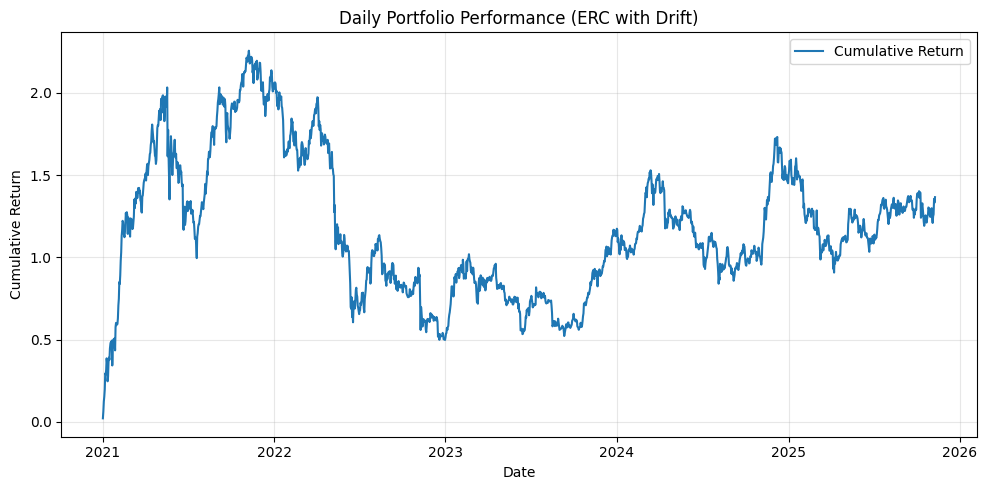

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(daily_portfolio.index, daily_portfolio.cumsum(), label="Cumulative Return")
plt.title("Daily Portfolio Performance (ERC with Drift)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()